# Steps for [tensorflow/tensorflow:latest-jupyter](https://hub.docker.com/r/tensorflow/tensorflow)

## For pip
- --upgrade pip
- sklearn
- opencv-python
- imutils

## For the OS
- apt-get update
- apt-get install libsm6 libxext6 ffmpeg -y

In [1]:
# Import Keras Stuff
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical

In [2]:
# Other Stuff
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.preprocessing import LabelBinarizer
%matplotlib inline
import matplotlib.pyplot as plt
from cv2 import imread, resize
from itertools import cycle
from imutils import paths
from scipy import interp
import numpy as np
import os

In [3]:
# Learning rate, number of epochs and batch size
EPOCHS = 20
LR = 1e-4
BS = 32

In [4]:
# Variables for loading all the images
image_paths = list(paths.list_images('rgb_dataset'))
dataset_folder = os.listdir('rgb_dataset')
dataset_sizes = [len(os.listdir('rgb_dataset/'+folder)) for folder in dataset_folder]
data = []
labels = [] 

In [5]:
%%time
for image_path in image_paths:
    # extract the class label from the filename
    label = image_path.split(os.path.sep)[-2]

    # load the input image (224x224) and preprocess it
    image = imread(image_path)
    image = resize(image, (224, 224))
    image = img_to_array(image)
    image = preprocess_input(image)

    # update the data and labels lists, respectively
    data.append(image)
    labels.append(label)

Wall time: 11.7 s


In [6]:
# convert the data and labels to NumPy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


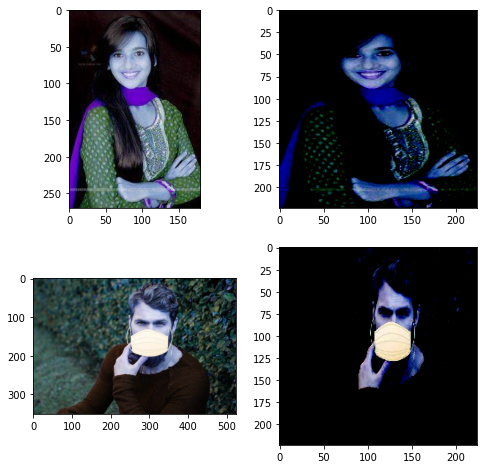

In [7]:
fig, axis = plt.subplots(2, 2, figsize=(8, 8))
axis[0,1].imshow(data[0])
axis[1,1].imshow(data[dataset_sizes[0]])
axis[0,0].imshow(imread(image_paths[0]))
axis[1,0].imshow(imread(image_paths[dataset_sizes[0]]))

In [8]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [9]:
# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
(X_train, X_test, y_train, y_test) = train_test_split(data, labels,
    test_size=0.20, stratify=labels, random_state=42)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


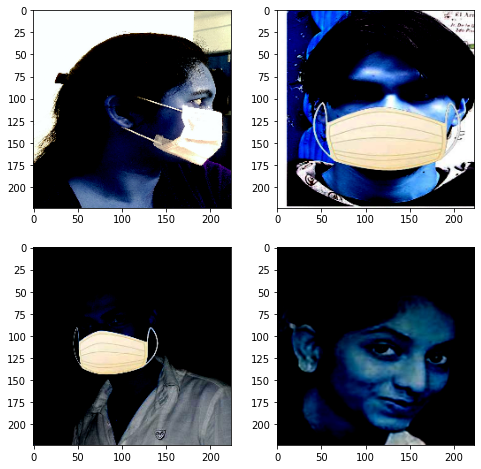

In [10]:
fig, axis = plt.subplots(2, 2, figsize=(8, 8))
axis[0,1].imshow(X_train[0])
axis[1,1].imshow(X_train[-1])
axis[0,0].imshow(X_test[0])
axis[1,0].imshow(X_test[-1])

In [11]:
# construct the training image generator for data augmentation
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

In [12]:
# load the MobileNetV2 network, ensuring the head FC layer sets are left off
base_model = MobileNetV2(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

In [13]:
# construct the head of the model that will be placed on top of the base model
head_model = base_model.output
head_model = AveragePooling2D(pool_size=(7, 7))(head_model)
head_model = Flatten(name="flatten")(head_model)
head_model = Dense(128, activation="relu")(head_model)
head_model = Dropout(0.5)(head_model)
head_model = Dense(2, activation="softmax")(head_model)

In [14]:
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=base_model.input, outputs=head_model)

In [15]:
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in base_model.layers:
    layer.trainable = False

In [16]:
# compile our model
opt = Adam(learning_rate=LR, decay=LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
    metrics=["accuracy"])

In [17]:
%%time
H = model.fit(
    aug.flow(X_train, y_train, batch_size=BS),
    steps_per_epoch=len(X_train) // BS,
    validation_data=(X_test, y_test),
    validation_steps=len(X_test) // BS,
    epochs=EPOCHS)

Epoch 1/20
34/34 [==============================] - 28s 762ms/step - loss: 0.5290 - accuracy: 0.7715 - val_loss: 0.2608 - val_accuracy: 0.9529
Epoch 2/20
34/34 [==============================] - 24s 708ms/step - loss: 0.2130 - accuracy: 0.9532 - val_loss: 0.1279 - val_accuracy: 0.9746
Epoch 3/20
34/34 [==============================] - 24s 711ms/step - loss: 0.1181 - accuracy: 0.9794 - val_loss: 0.0832 - val_accuracy: 0.9746
Epoch 4/20
34/34 [==============================] - 24s 711ms/step - loss: 0.0925 - accuracy: 0.9794 - val_loss: 0.0605 - val_accuracy: 0.9819
Epoch 5/20
34/34 [==============================] - 25s 719ms/step - loss: 0.0673 - accuracy: 0.9878 - val_loss: 0.0482 - val_accuracy: 0.9855
Epoch 6/20
34/34 [==============================] - 24s 706ms/step - loss: 0.0573 - accuracy: 0.9916 - val_loss: 0.0405 - val_accuracy: 0.9891
Epoch 7/20
34/34 [==============================] - 25s 735ms/step - loss: 0.0493 - accuracy: 0.9899 - val_loss: 0.0352 - val_accuracy: 0.9891

In [18]:
# make predictions on the testing set
y_score = model.predict(X_test, batch_size=BS)

In [19]:
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predicts = np.argmax(y_score, axis=1)

In [20]:
# show a nicely formatted classification report
print(classification_report(y_test.argmax(axis=1), predicts,
    target_names=lb.classes_))

              precision    recall  f1-score   support

   with_mask       0.99      1.00      1.00       138
without_mask       1.00      0.99      1.00       138

    accuracy                           1.00       276
   macro avg       1.00      1.00      1.00       276
weighted avg       1.00      1.00      1.00       276



In [21]:
# serialize the model to disk
model.save('rgb_mask_detector.model', save_format="h5")

d:\guita\documents\code\python\covidfacemask\thermal-mask\venv\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [22]:
# plot the training loss and accuracy
def make_graph(axis, x, y1, y2, label_1, label_2, title, x_label, y_label):
    line_1, = axis.plot(x, y1)
    line_1.set_label(label_1)
    line_2, = axis.plot(x, y2)
    line_2.set_label(label_2)
    axis.legend()
    axis.set_title(title)
    axis.set_xlabel(x_label)
    axis.set_ylabel(y_label)
    return ax1, ax2

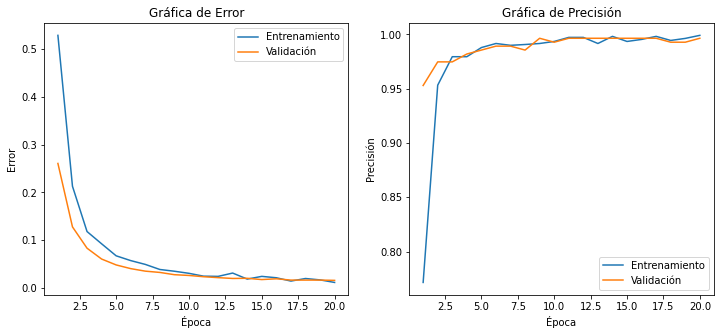

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
make_graph(ax1, np.arange(1, EPOCHS + 1), H.history["loss"], H.history["val_loss"], 'Entrenamiento', 'Validación', 'Gráfica de Error', 'Época', 'Error')
make_graph(ax2, np.arange(1, EPOCHS + 1), H.history["accuracy"], H.history["val_accuracy"], 'Entrenamiento', 'Validación', 'Gráfica de Precisión', 'Época', 'Precisión')
plt.savefig("rgb_training_plot.jpg")
plt.show()

In [24]:
H.history["accuracy"][-1]

0.9990636706352234

In [25]:
H.history["val_accuracy"][-1]

0.9963768124580383